Simple 2d power spectra generation (random gaussian field) with some simple analysis run on the position space results.  Inspired by the [Cosmic Microwave Background (CMB)](https://en.wikipedia.org/wiki/Cosmic_microwave_background); see [my website](https://garrettgoon.com/gaussian-fields/) for more background information.

TODO:

-Extend to higher dimensions

-Theory might be more frequently over-predicts the correlations, rather than underpredicting them? By eye, at least. Needs more testing

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.stats as stats
import corner

from scipy.optimize import minimize
from scipy.special import gamma

Create a class for generating the power spectrum.  Spectra are characterized by an amplitude and power-law exponent: $\langle \phi(k)\phi(-k)\rangle'=\frac{\rm amplitude}{k^{\rm power}}\equiv P(k)$, corresponding in position space to $\langle \phi(x)\phi(0)\rangle\propto \frac{\rm amplitude}{x^{d-{\rm power}}}\equiv G(x)$ in $d$-dimensions. Grid size is $2^{\rm size\_exponent}$ and ${\rm dimensions}=2$ is the number of spatial dimensions; expansion to other dimensions to come later.  
    
Methods: 

- _generate_: generate realization of desired power spectrum
- _spectrum_plot_: visualization of generated spectra
- _hist_: histogram of generated values (should be normally distributed)
- _bin_pair_data_: pair data and bin to find correlation function
- _data_fit_: plot binned data vs. simple linear regression fit and theory line
- _bayes_: simple bayesian analysis on _amplitude_ and _power_ parameters using flat priors
    


In [255]:
class CmbPy():
    def __init__(self, amplitude=1, power=1.75, size_exponent=3, dimensions=2):
        self.amplitude = amplitude
        self.power = power
        self.size = 2**(size_exponent)
        self.dimensions = dimensions

    def _theory_xspace(self, theta, x):
        amplitude, power = theta
        """
            The theoretical position-space correlator, given the model parameters. Only valid for 2d right now
            """
        return 1 / (np.pi * (2**power)) * amplitude * x**(
            power - 2) * gamma(1 - power / 2) / gamma(power / 2)

    def generate(self):
        """
        generating the spectrum
        """
        # creating a grid w/ each point pulled from std normal
        gaussian_seed = np.random.normal(
            size=[self.size for _ in range(self.dimensions)])
        # fourier transform
        gaussian_seed_fourier = np.fft.fft2(gaussian_seed)
        # numpy's fft algorithm automatically indexes with negative values on right half
        # positive on left half, as desired

        # relevant momenta vectors with desired fft indexing
        kvector = [(2*np.pi/self.size)*i for i in range(int(self.size/2+1))]+ \
        [(2*np.pi/self.size)*i for i in range(int(-self.size/2+1), 0)]

        # power spectrum function
        def power_spectrum(i, j):
            # regulating the k=0 divergence:
            if i == j == 0:
                return 0
            else:
                ktotal = np.sqrt(kvector[i]**2 + kvector[j]**2)
                return self.amplitude * (ktotal**(-self.power))

        # create grid of relevant (square-root of) power spectrum values
        power_grid_sqrt = np.array(
            [[np.sqrt(power_spectrum(i, j)) for i in range(self.size)]
             for j in range(self.size)])

        # multiply by the transformed white noise
        fourier_spectrum = gaussian_seed_fourier * power_grid_sqrt

        # transform back and take the real part to get the spectrum
        self.spectrum = np.real(np.fft.ifft2(fourier_spectrum))

        # imaginary parts are from numerical errors; they're very small
        im_to_re_ratio = np.imag(np.fft.ifft2(fourier_spectrum)) / np.real(
            np.fft.ifft2(fourier_spectrum))

        print(
            'Sanity check: ratio of imaginary to real components in generated data:'
        )
        print(
            f'Average ratio: {np.mean(im_to_re_ratio)} Standard dev.: {np.std(im_to_re_ratio)}'
        )

    def spectrum_plot(self):
        """
        plotting the spectrum
        """
        if hasattr(self, 'spectrum'):
            _, ax = plt.subplots()
            ax.imshow(self.spectrum)
            plt.show()
        else:
            print('Run generate to create spectrum first')

    def hist(self):
        """
        histogram of generated values
        """

        if not hasattr(self, 'spectrum'):
            return print('Run generate to create spectrum first')

        data = self.spectrum.flatten()
        std = np.std(data)
        self.std = std
        # plot data
        _, ax = plt.subplots()
        ax.hist(data, bins=100, density=True)
        ax.set_xlabel(f'$\sigma$={std:.5f}')
        ax.set_ylabel('$\phi$')
        ax.set_title('Distribution of generated points')
        # plot fit
        x = np.linspace(-5 * std, 5 * std, 100)
        y = stats.norm.pdf(x, 0, std)
        ax.plot(x, y)
        plt.show()

    def bin_pair_data(self, maxlen=None):
        """
        Collect all independent pairs of data points separated by less than maxlen
        and bin them by distance, rounding to nearest integer.  
        
        getting the various relevant data points from the position-space spectrum
        data points are tuples containing an array with the two signals
        and two more arrays with their locations
        maxlen throws out all data points whose distance is larger than maxlen
        (bottleneck, should improve)
        """
        # dynamically choosing maxlen:
        if maxlen == None:
            maxlen = int(self.size // 10)

        print('Collecting pair data...')

        #dictionary to hold data
        binned_pair_data = {i: np.array([]) for i in range(1, maxlen + 1)}
        # bin pair data
        for i in range(self.size):
            for j in range(self.size):
                for a in range(i + 1, min(self.size, i + maxlen)):
                    for b in range(j + 1, min(self.size, j + maxlen)):
                        d2 = (i - a)**2 + (j - b)**2
                        dint = int(round(np.sqrt(d2)))
                        if dint in binned_pair_data:
                            binned_pair_data[dint] = np.append(
                                binned_pair_data[dint],
                                self.spectrum[i][j] * self.spectrum[a][b])

        # compute how many data pairs were analyzed
        pts = 0
        for item in binned_pair_data:
            pts += len(binned_pair_data[item])
        print('Independent data pairs analyzed:', pts)

        # compute summary statistics: (x,y_bar,std(y_bar)) with y_bar=<y>
        data_summary = np.array([[
            key,
            np.mean(binned_pair_data[key]),
            np.std(binned_pair_data[key]) /
            np.sqrt(len(binned_pair_data[key]))
        ] for key in binned_pair_data if len(binned_pair_data[key])>0])

        self.binned_pair_data = binned_pair_data
        self.data_summary = data_summary

    def data_fit(self):
        """
        plot binned summary data against simple regression fit and theory prediction
        """
        if not hasattr(self, 'data_summary'):
            return print('Run bin_pair_data first')

        # plotting
        _, ax = plt.subplots()
        # data points
        data_T = self.data_summary.T
        x_data, y_data, y_errs = data_T[0, :], data_T[1, :], data_T[2, :]
        ax.errorbar(x_data, y_data, yerr=y_errs, marker='.', color='k')

        # Least-squares fitting for scaling ansatz that G(x)=amplitude/x^(x_power)
        # logs of data points
        log_x_data = np.array([[1, np.log(value)] for value in x_data])
        # use abs on correlator values, just to prevent errors on ln
        # only affects very low-resolution data since all y values should be positive
        # good enough for a rough check
        log_y_data = np.array([np.log(np.abs(value)) for value in y_data])
        # errors in log(y) are
        log_y_errs = np.array([[y_errs[i] / y_data[i], y_errs[i] / y_data[i]]
                               for i in range(len(y_errs))])
        log_x_data_div_x = log_x_data / log_y_errs
        log_x_data_div_x2 = log_x_data_div_x / log_y_errs
        # simple LS analysis using individual errors:
        log_y_data = log_y_data.reshape([-1, 1])
        xx_matrix = log_x_data_div_x.T.dot(log_x_data_div_x)
        beta_cov_matrix = np.linalg.inv(xx_matrix)
        # best-fit values for (log(amplitude),-x_power):
        beta_fit = beta_cov_matrix.dot(log_x_data_div_x2.T).dot(log_y_data)

        # least-squares fit plotting:
        def y_ls_fit(x):
            return np.exp(beta_fit[0]) * (x**(beta_fit[1]))

        x_fit = np.linspace(x_data[0], x_data[-1], num=100)
        y_fit = y_ls_fit(x_fit)
        ax.plot(x_fit, y_fit, linestyle='-', color='r', label='least-squares')

        # plotting theory prediction:
        y_theory = self._theory_xspace((self.amplitude, self.power), x_fit)
        ax.plot(x_fit, y_theory, linestyle=':', color='m', label='theory')

        # labelling and legends
        x_power = -beta_fit[1][0]
        k_power = x_power - self.dimensions
        ax.set_title(
            f'$G^{{fit}}(x)\\approx  {np.exp(beta_fit[0][0]):.3f} \\cdot x^{{{-x_power:.3f}}}\ , \\quad G^{{theory}}(x)\\approx  {1/(np.pi*(2**self.power))*self.amplitude*gamma(1-self.power/2)/gamma(self.power/2):.3f} \\cdot x^{{{self.power-self.dimensions:.3f}}} $'
        )
        ax.set_xlabel('$x$')
        ax.set_ylabel('$\\langle \\phi(x)\\phi(0)\\rangle\equiv G(x)$')
        ax.legend()
        plt.show()

        # save fit results
        self.lr_fit = {'beta': beta_fit, 'beta_cov': beta_cov_matrix}

    def bayes(self, nsteps=10**4, walkers=2**6):
        """
        bayesian analysis for power-spectrum parameters using binned data
        """

        if not hasattr(self, 'data_summary'):
            return print('Run data_fit first')

        # set flat priors on the amplitude and power over some range covering actual values
        amp_max, power_max = 3 * self.amplitude, 10

        def log_prior(theta):
            amplitude, power = theta
            if 0 < amplitude < amp_max and 0 < power < power_max:
                return 0.0
            return -np.inf

        def log_likelihood(theta, data):
            x, y, sigy = data
            return np.sum(-np.log(sigy) - .5 *
                          (self._theory_xspace(theta, x) - y)**2 / sigy**2)

        # total log-prob needed for MCMC
        def log_posterior(theta, data):
            lp = log_prior(theta)
            if not np.isfinite(lp):
                return -np.inf
            return lp + log_likelihood(theta, data)

        # MCMC setup
        # distribute initial walker positions around LR best fit
        # recall the stored fits are for (log(amplitude),-x_power) with G(x)=amplitude/x^(x_power) and
        # x_power=2-power
        initial = np.array(
            [np.exp(self.lr_fit['beta'][0]), 2 + self.lr_fit['beta'][1]])
        pos = initial.T + .05 * np.concatenate(
            (np.random.uniform(-initial[0], initial[0], (walkers, 1)),
             np.random.uniform(-initial[1], initial[1], (walkers, 1))),
            axis=1)
        walkers, dim = pos.shape

        sampler = emcee.EnsembleSampler(walkers,
                                        dim,
                                        log_posterior,
                                        args=[self.data_summary.T])
        sampler.run_mcmc(pos, nsteps, progress=True)
        samples = sampler.get_chain()

        # plotting chain convergence
        fig, axs = plt.subplots(2)
        for i in range(walkers):
            for j in range(dim):
                axs[j].plot(samples[:, i, j])

        axs[0].set_ylabel('amp')
        axs[1].set_ylabel('power')
        fig.suptitle('Chain convergence')
        plt.show()

        # autocorrelation analysis
        auto_corr = sampler.get_autocorr_time()
        thin_rate = int(np.mean(np.array(auto_corr)) // 2)

        # burn 1/4 of data, then make corner plots
        flat_samples = sampler.get_chain(discard=int(nsteps // 4),
                                         thin=thin_rate,
                                         flat=True)
        amp_samples, power_samples = flat_samples[:, 0], flat_samples[:, 1]

        fig = corner.corner(flat_samples,
                            labels=['amp', 'power'],
                            truths=[self.amplitude, self.power],
                            truth_color='r')
        fig.suptitle(
            f'Actual values: (amp,power)=({self.amplitude:.2f},{self.power:.2f})'
        )
        plt.show()

Then run a realization and analyze.  Choose the amplitude and power randomly from some range

amplitude: 2.50 
power: 0.83
Sanity check: ratio of imaginary to real components in generated data:
Average ratio: 5.065737154837025e-16 Standard dev.: 2.5511681369257545e-14


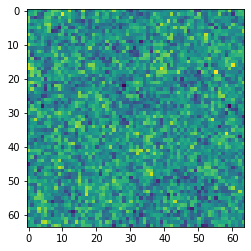

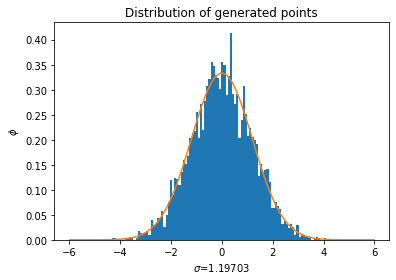

Independent data pairs analyzed: 911163


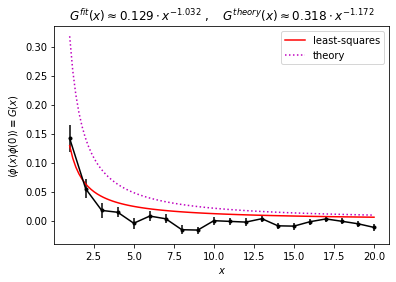

100%|██████████| 5000/5000 [00:19<00:00, 253.00it/s]


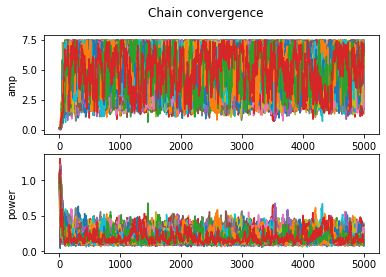

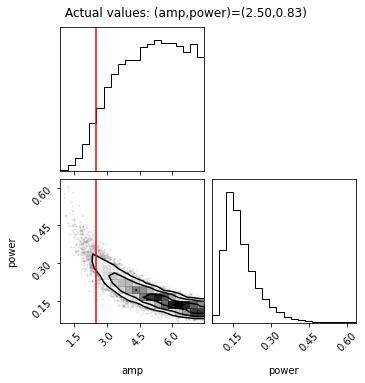

In [260]:

rand_amp,rand_power=np.random.uniform(0,10,1)[0],np.random.uniform(.2,1.5,1)[0]
print(f'amplitude: {rand_amp:.2f}',f'\npower: {rand_power:.2f}')

c = CmbPy(size_exponent=6, amplitude=rand_amp, power=rand_power)
c.generate()
c.spectrum_plot()
c.hist()
c.bin_pair_data(maxlen=20)
c.data_fit()
c.bayes(nsteps=5*10**3,walkers=64)